# Projeto de Modelo Classificatório para Previsão do Fechamento da Bolsa em “Alta” ou “Baixa”

O objetivo proposto no projeto é desenvolvê-lo como parte do time de investimentos, onde minha tarefa é criar um modelo preditivo com dados da Bovespa para prever diariamente o fechamento do índice. Para isso, utilizei a base de dados disponível no site da Investing, selecionando o período diário com um intervalo de tempo adequado.

* O Processo:

Desde a coleta inicial dos dados até a fase final de entrega do modelo, meu objetivo primordial foi desenvolver uma narrativa clara e concisa para toda a equipe de análise de dados.

Primeiramente, realizei a coleta dos dados da Bovespa, seguida pela análise exploratória para compreender a estrutura dos dados e identificar possíveis padrões. Em seguida, o processo de modelagem envolveu a escolha e justificação da técnica apropriada. Optei pelo Light GBM, aproveitando o Optuna para aprimoramento dos hiperparâmetros. Essa escolha foi cuidadosamente fundamentada, considerando a complexidade do problema e o objetivo de atingir uma acurácia superior a 70%.

*	Justificativa da Técnica:

Diante da dificuldade em prever um valor exato de fechamento da bolsa devido à sua complexidade, optei por uma abordagem inovadora: criar um modelo de classificação. Essa decisão foi fundamentada na ideia de que, ao prever se o fechamento da bolsa seria "alta" ou "baixa" com base na abertura do dia, seria possível obter insights valiosos e uma maior confiança nas previsões.

*	Destaque do Projeto:

Um ponto interessante deste projeto foi escolher transformar um modelo preditivo em classificatório. Embora tenha sido uma decisão que exigiu análise cuidadosa, em uma situação real, eu defenderia essa abordagem com confiança. Acredito que, ao lidar com dados, é crucial ser criativo para alcançar resultados significativos para a organização. Essa mudança de estratégia trouxe insights valiosos e reforçou minha confiança nas previsões realizadas.

Essa experiência de transformar dados em insights úteis mostra não só como as técnicas de modelagem são aplicadas na prática, mas também destaca o valor de ser criativo e flexível ao analisar dados financeiros.

Link para acessar o PowerPoint desenvolvido, fundamental para entender melhor o projeto de modelagem apresentado. Este material é importante para explicar as estratégias utilizadas e os resultados alcançados.

*   https://docs.google.com/presentation/d/1Tc-65c08JHWycKo4t4LbKKjIS1XVTdgv/edit?usp=sharing&ouid=112709212936358032920&rtpof=true&sd=true


Link para base de dados utilizada:

*	https://drive.google.com/file/d/1U719N_212vTV3OJLOqaf7-qKdoFaNzGh/view?
usp=sharing

Extraída de:

* https://br.investing.com/indices/bovespa-historical-data

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import os
import sqlite3
import optuna
import lightgbm as lgb
from lightgbm import LGBMClassifier
from getpass import getpass
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
import warnings
import ipywidgets as widgets
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Para ignorar mensagens de aviso
warnings.filterwarnings("ignore")

# Tratando os dados

In [ ]:
# Importando base

df = pd.read_csv(r'C:\Users\CPU\Documents\Repositories\Study\Data_Science_Projects\Studies\Data\dados_ibovespa_2005_2024.csv', sep=',')

In [ ]:
# Deixando as colunas com letras minúsculas

df.columns = [col.lower() for col in df.columns]

In [ ]:
# Renomeando as colunas

df = df.rename(columns={'último': 'fechamento', 'máxima': 'vlr_max', 'mínima': 'vlr_min', 'vol.': 'volumetria$', 'var%': 'variacao%'})

In [ ]:
# Vendo infos primarias do df

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4720 entries, 0 to 4719
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data         4720 non-null   object 
 1   fechamento   4720 non-null   float64
 2   abertura     4720 non-null   float64
 3   vlr_max      4720 non-null   float64
 4   vlr_min      4720 non-null   float64
 5   volumetria$  4719 non-null   object 
 6   variacao%    4720 non-null   object 
dtypes: float64(4), object(3)
memory usage: 258.3+ KB


In [ ]:
# Definindo a coluna data como datetime

df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')

In [ ]:
# Função para converter a coluna volumetria$ em float

def convert_vol(val):
    if isinstance(val, float):
        return val
    elif 'M' in val:
        return float(val.replace('M', '').replace(',', '.')) * 1_000_000
    elif 'K' in val:
        return float(val.replace('K', '').replace(',', '.')) * 1_000
    else:
        return float(val.replace(',', '.'))

df['volumetria$'] = df['volumetria$'].apply(convert_vol)

In [ ]:
# Função para converter a coluna variacao% em float

df['variacao%'] = df['variacao%'].str.replace('%', '').str.replace(',', '.').astype(float)

In [ ]:
# Ordenando o df pela data

df = df.sort_values('data')

In [ ]:
# Vendo as 5 primeiras linhas do df

df.head()

,data,fechamento,abertura,vlr_max,vlr_min,volumetria$,variacao%
4719,2005-01-03,25.722,26.193,26.492,25.671,115640000.0,-1.81
4718,2005-01-04,24.848,25.722,25.873,24.791,146140000.0,-3.40
4717,2005-01-05,24.692,24.859,25.001,24.523,127420000.0,-0.63
4716,2005-01-06,24.367,24.695,24.808,24.250,151170000.0,-1.32
4715,2005-01-07,24.747,24.376,24.874,24.376,104960000.0,1.56


In [ ]:
# Vendo se temos valores nulos

df.isnull().sum()

data                     0
fechamento               0
abertura                 0
vlr_max                  0
vlr_min                  0
                        ..
std_volumetria$_360d     0
mean_volumetria$_540d    0
std_volumetria$_540d     0
target                   0
predict_target           0
Length: 93, dtype: int64

In [ ]:
# Vendo estrutura do df

df.shape

(4720, 7)

In [ ]:
# Removendo valores nulos

df = df.dropna()

In [ ]:
# Vendo estrutura do df

df.shape

(4719, 7)

# Analisando os dados

In [ ]:
# Informações estatísticas do df

df.describe()

,data,fechamento,abertura,vlr_max,vlr_min,volumetria$,variacao%
count,4720,4720.000000,4720.000000,4720.000000,4720.000000,4.719000e+03,4720.000000
mean,2014-07-16 19:08:38.644067840,69.415254,69.394648,70.086634,68.708824,2.077256e+07,0.048161
min,2005-01-03 00:00:00,23.610000,23.618000,24.006000,23.534000,1.121000e+05,-14.780000
25%,2009-10-06 18:00:00,51.204750,51.194750,51.652250,50.537750,2.750000e+06,-0.830000
50%,2014-07-19 12:00:00,61.962000,61.960500,62.601500,61.387000,4.210000e+06,0.070000
75%,2019-04-29 06:00:00,93.616750,93.589250,94.535750,92.419250,1.089000e+07,0.970000
max,2024-01-25 00:00:00,134.194000,134.194000,134.389000,133.832000,9.553700e+08,14.660000
std,NaN,26.944783,26.939300,27.115860,26.765982,4.440278e+07,1.699312


In [ ]:
# Vendo a correlação entre as variáveis

df.corr()

,data,fechamento,abertura,vlr_max,vlr_min,volumetria$,variacao%
data,1.000000,0.852790,0.852785,0.853595,0.852405,-0.472913,-0.006086
fechamento,0.852790,1.000000,0.999124,0.999620,0.999696,-0.377444,0.013220
abertura,0.852785,0.999124,1.000000,0.999651,0.999478,-0.377915,-0.025702
vlr_max,0.853595,0.999620,0.999651,1.000000,0.999515,-0.378650,-0.006470
vlr_min,0.852405,0.999696,0.999478,0.999515,1.000000,-0.377098,-0.002048
volumetria$,-0.472913,-0.377444,-0.377915,-0.378650,-0.377098,1.000000,0.018713
variacao%,-0.006086,0.013220,-0.025702,-0.006470,-0.002048,0.018713,1.000000


<Axes: >

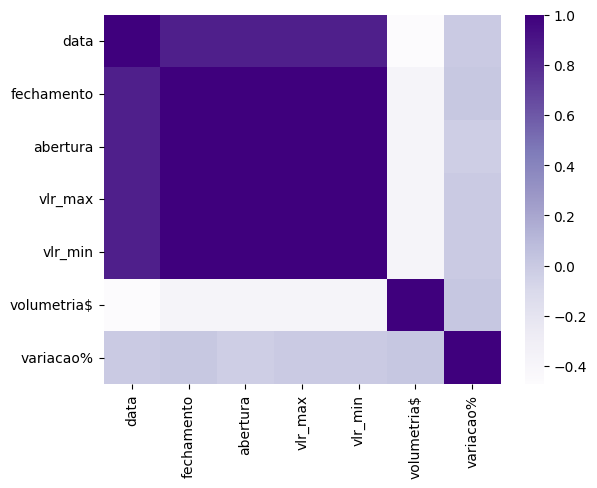

In [ ]:
# Heatmap da correlação
sns.heatmap(df.corr(), cmap='Purples')

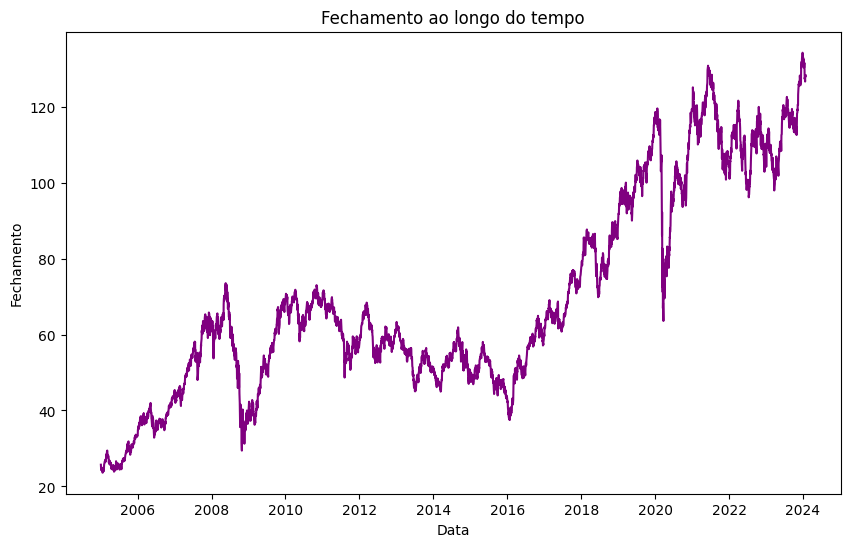

In [ ]:
# Plotando gráfico da coluna Fechamento ao longo do tempo

plt.figure(figsize=(10, 6))
plt.plot(df['data'], df['fechamento'], color='purple')
plt.title('Fechamento ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.show()

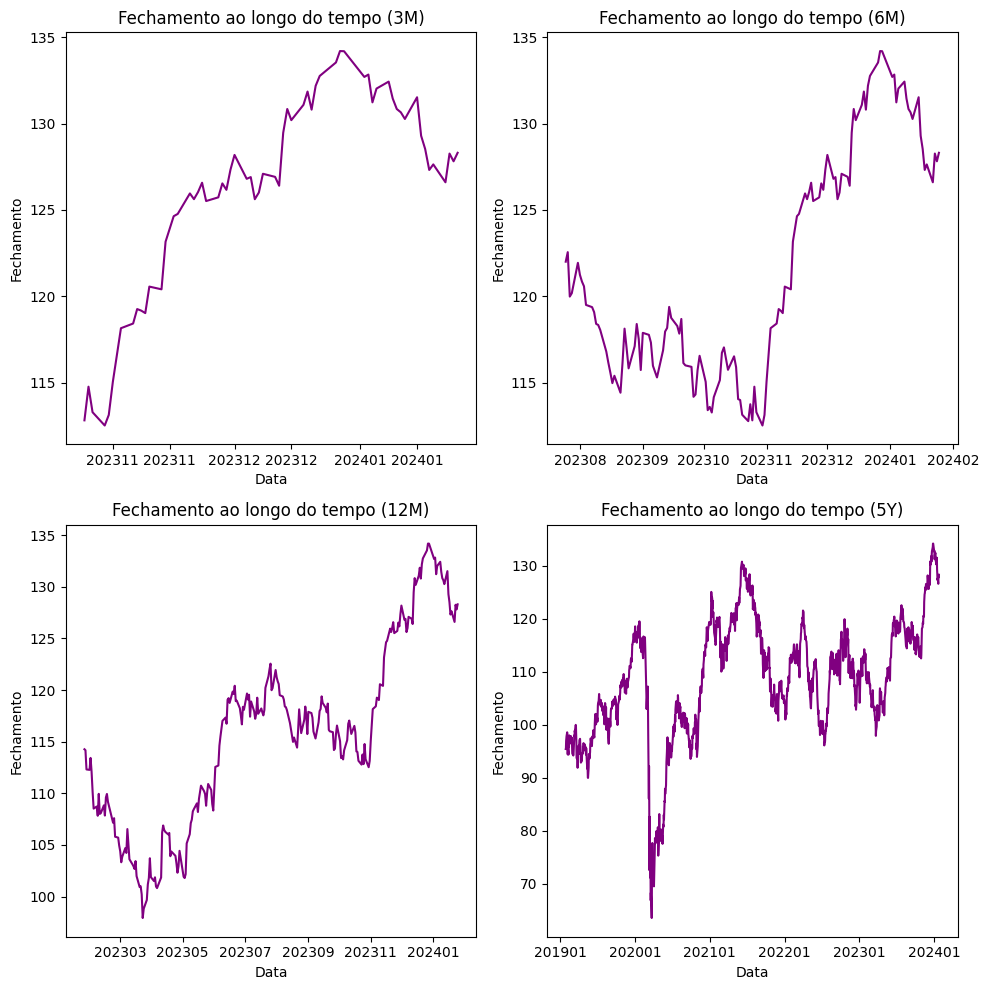

In [ ]:
# Plotando gráfico da coluna Fechamento ao longo de intervalos de tempo

# Definiindo as janelas de tempo
windows = ['3M', '6M', '12M', '5Y']

fig, axs = plt.subplots(nrows=len(windows)//2, ncols=2, figsize=(10, 10))

for i, window in enumerate(windows):
    # Filtrando os dados para a janela de tempo atual
    end_date = df['data'].max()
    start_date = end_date - pd.DateOffset(months=int(window[:-1])) if window[-1] == 'M' else end_date - pd.DateOffset(years=int(window[:-1]))
    filtered_df = df[(df['data'] >= start_date) & (df['data'] <= end_date)]

    # Plotando os dados filtrados
    axs[i//2, i%2].plot(filtered_df['data'], filtered_df['fechamento'], color='purple')
    axs[i//2, i%2].set_title(f'Fechamento ao longo do tempo ({window})')
    axs[i//2, i%2].set_xlabel('Data')
    axs[i//2, i%2].set_ylabel('Fechamento')

    # Formatando o eixo y para 'YYYYMM'
    date_format = mdates.DateFormatter('%Y%m')
    axs[i//2, i%2].xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()

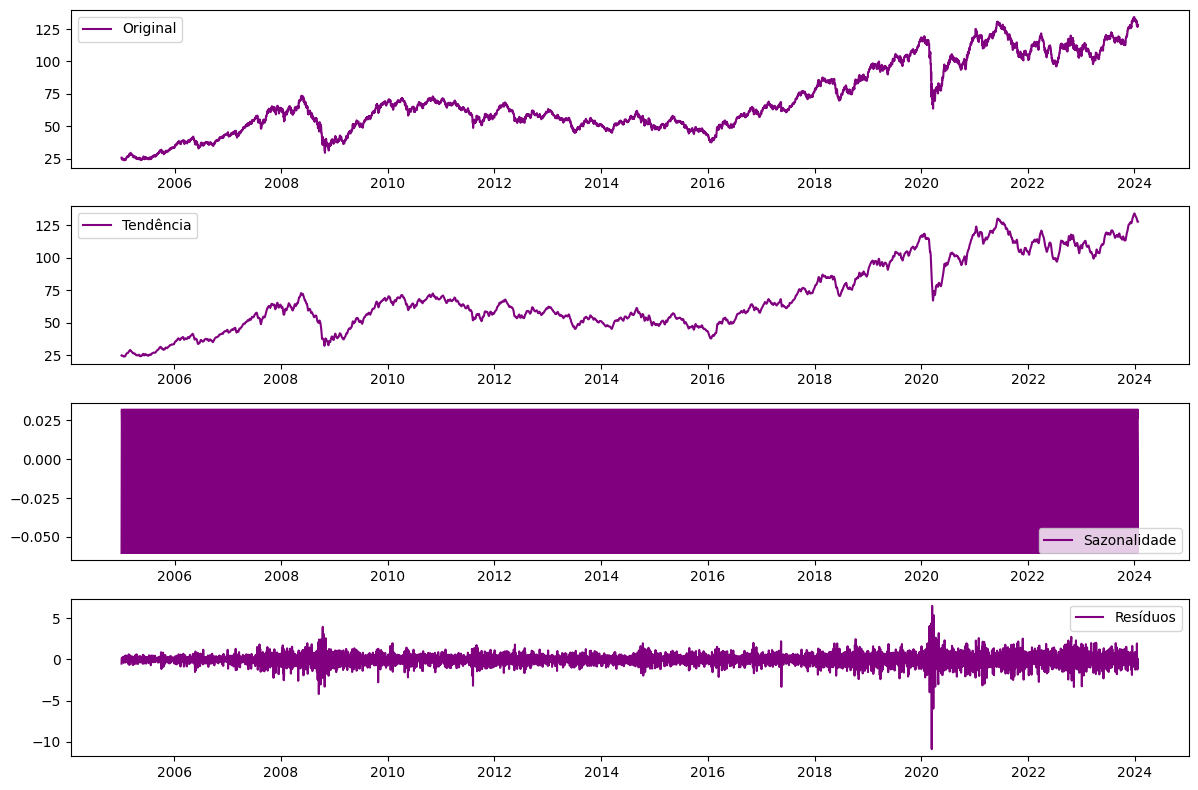

In [ ]:
# Plotando gráfico da Sazonalidade, Tendência e Resíduos

# Criar uma cópia do DataFrame
df_copy = df.copy()

# Certifique-se de que a cópia do DataFrame está indexada por uma coluna de data
df_copy.index = pd.to_datetime(df_copy['data'])

# Resample para frequência diária, use ffill() para preencher quaisquer lacunas
df_copy = df_copy.resample('D').ffill()

# Decomposição sazonal
decomposition = seasonal_decompose(df_copy['fechamento'], model='additive')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df_copy['fechamento'], label='Original', color='purple')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendência', color='purple')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Sazonalidade', color='purple')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Resíduos', color='purple')
plt.legend(loc='best')
plt.tight_layout()

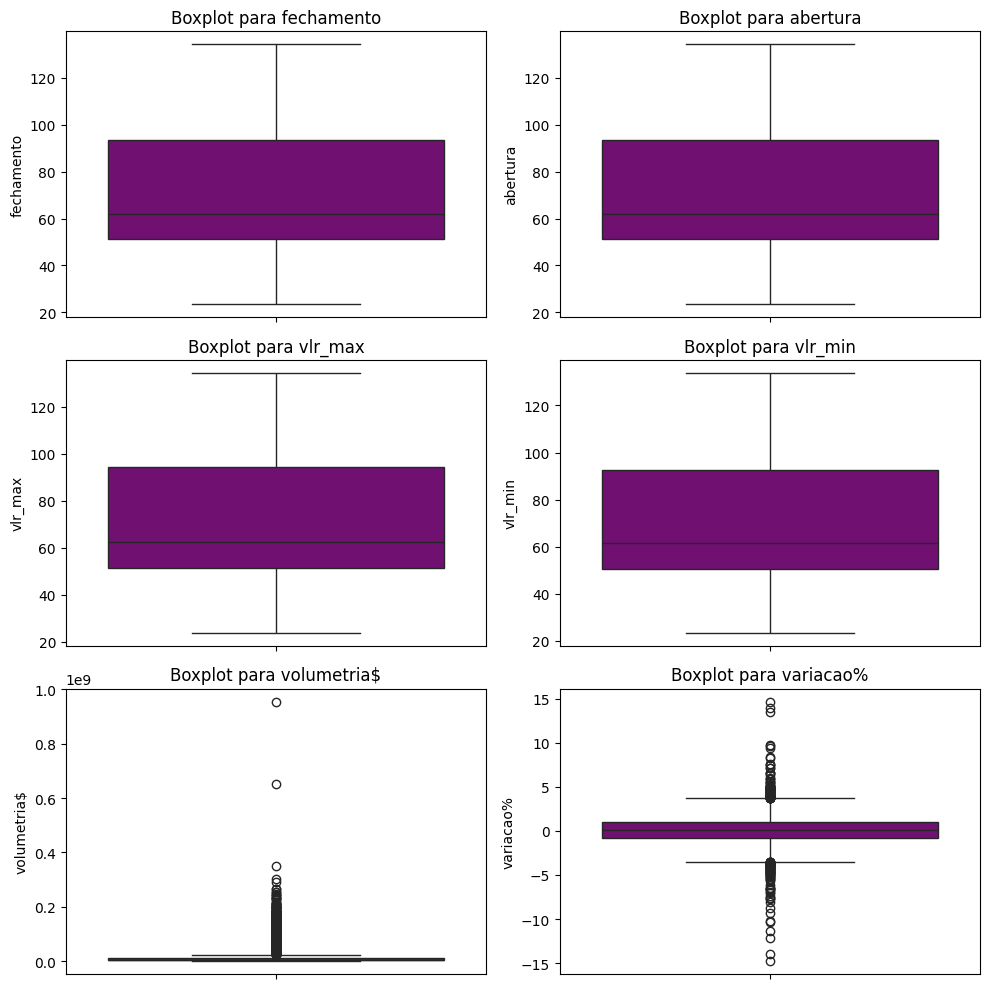

In [ ]:
# Boxplots para avaliar se existem outliers

columns = ['fechamento', 'abertura', 'vlr_max', 'vlr_min', 'volumetria$', 'variacao%']

fig, axs = plt.subplots(nrows=len(columns)//2, ncols=2, figsize=(10, 10))

for i, column in enumerate(columns):
    sns.boxplot(y=df[column], ax=axs[i//2, i%2], color='purple')
    axs[i//2, i%2].set_title(f'Boxplot para {column}')

plt.tight_layout()
plt.show()

[I 2024-01-28 20:51:18,764] A new study created in RDB with name: study
[I 2024-01-28 20:52:30,172] Trial 0 finished with value: 1.351838055543483 and parameters: {'p': 1, 'd': 2, 'q': 2, 'P': 1, 'D': 2, 'Q': 1, 's': 14}. Best is trial 0 with value: 1.351838055543483.
[I 2024-01-28 20:52:53,638] Trial 1 finished with value: 1.6103927458072562 and parameters: {'p': 2, 'd': 1, 'q': 2, 'P': 3, 'D': 1, 'Q': 0, 's': 7}. Best is trial 1 with value: 1.6103927458072562.
[I 2024-01-28 20:53:00,492] Trial 2 finished with value: 1.235987582533 and parameters: {'p': 3, 'd': 2, 'q': 0, 'P': 3, 'D': 1, 'Q': 0, 's': 14}. Best is trial 1 with value: 1.6103927458072562.
[I 2024-01-28 20:53:11,133] Trial 3 finished with value: 1.106222169526767 and parameters: {'p': 3, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 1, 's': 7}. Best is trial 1 with value: 1.6103927458072562.
[I 2024-01-28 20:54:06,984] Trial 4 finished with value: 1.09378807929606 and parameters: {'p': 2, 'd': 0, 'q': 0, 'P': 2, 'D': 1, 'Q': 2, 's

                                     SARIMAX Results                                      
Dep. Variable:                         fechamento   No. Observations:                 6962
Model:             SARIMAX(2, 1, 2)x(3, 1, [], 7)   Log Likelihood              -10044.226
Date:                            Sun, 28 Jan 2024   AIC                          20104.452
Time:                                    20:54:30   BIC                          20159.229
Sample:                                01-03-2005   HQIC                         20123.334
                                     - 01-25-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0486      0.003    -19.426      0.000      -0.054      -0.044
ar.L2          0.9461      0.002   

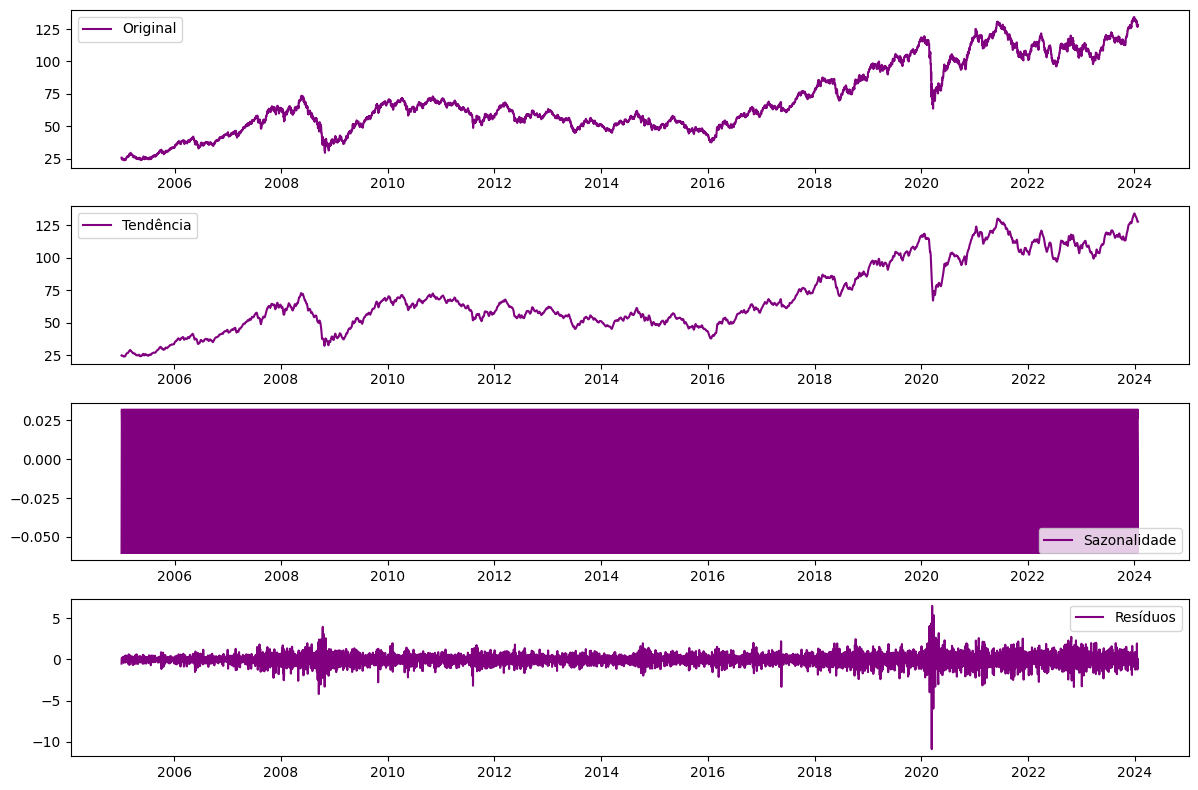

In [ ]:
# Função para rodar o algoritimo SARIMAX que é um modelo de previsão de séries temporais

#try:
#    storage = optuna.storages.get_storage("sqlite:///study.db")
#except:
#    os.mknod("study.db")
#    storage = optuna.storages.get_storage("sqlite:///study.db")
#
#
## Criar uma cópia do DataFrame
#df_copy = df.copy()
#
## Certifique-se de que a cópia do DataFrame está indexada por uma coluna de data
#df_copy.index = pd.to_datetime(df_copy['data'])
#
## Resample para frequência diária, use ffill() para preencher quaisquer lacunas
#df_copy = df_copy.resample('D').ffill()
#
## Decomposição sazonal
#decomposition = seasonal_decompose(df_copy['fechamento'], model='additive')
#
#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid
#
#plt.figure(figsize=(12,8))
#plt.subplot(411)
#plt.plot(df_copy['fechamento'], label='Original', color='purple')
#plt.legend(loc='best')
#plt.subplot(412)
#plt.plot(trend, label='Tendência', color='purple')
#plt.legend(loc='best')
#plt.subplot(413)
#plt.plot(seasonal,label='Sazonalidade', color='purple')
#plt.legend(loc='best')
#plt.subplot(414)
#plt.plot(residual, label='Resíduos', color='purple')
#plt.legend(loc='best')
#plt.tight_layout()
#
## Função para otimização dos parâmetros do modelo ARIMA
#def objective(trial):
#    p = trial.suggest_int('p', 0, 3)
#    d = trial.suggest_int('d', 0, 2)
#    q = trial.suggest_int('q', 0, 3)
#
#    P = trial.suggest_int('P', 0, 3)
#    D = trial.suggest_int('D', 0, 2)
#    Q = trial.suggest_int('Q', 0, 3)
#    s = trial.suggest_categorical('s', [7, 14, 21, 28])  # supondo que a sazonalidade seja semanal, bi-semanal, tri-semanal ou mensal para dados diários.
#
#    model = SARIMAX(df_copy['fechamento'], order=(p,d,q), seasonal_order=(P,D,Q,s))
#    model_fit = model.fit(disp=False)
#
#    preds = model_fit.predict(len(df_copy)-10, len(df_copy)-1)
#    mse = mean_squared_error(df_copy['fechamento'][-10:], preds)
#
#    return mse
#
#study = optuna.create_study(study_name="study", storage=storage, direction="maximize")
#study.optimize(objective, n_trials=5)
#
#best_params = study.best_params
#
## Treinar o modelo com os melhores parâmetros encontrados
#model = SARIMAX(df_copy['fechamento'], order=(best_params['p'], best_params['d'], best_params['q']),
#                seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['s']))
#model_fit = model.fit(disp=False)
#
## Imprimir o resumo do modelo
#print(model_fit.summary())

# Criando variáveis e target

In [ ]:
# Criando variáveis

# Listando as colunas para as quais calcular as médias móveis e os desvios padrão móveis
columns = ['fechamento', 'variacao%', 'abertura', 'vlr_max', 'vlr_min', 'volumetria$']

# Calculando as médias móveis e os desvios padrão móveis para cada coluna especificada
for column in columns:
    for window in [2, 5, 30, 90, 180, 360, 540]:  # Intervalo de dias para 2 dias, 5 dias, 1 mês, 3 meses, 6 meses, 12 meses e 18 meses
        mean_col = f'mean_{column}_{window}d'
        std_col = f'std_{column}_{window}d'

        df[mean_col] = df[column].rolling(window).mean()
        df[std_col] = df[column].rolling(window).std()

        # Preenchendo os valores nulos com a mediana da coluna
        df[mean_col].fillna(df[mean_col].median(), inplace=True)
        df[std_col].fillna(df[std_col].median(), inplace=True)

df.head()

,data,fechamento,abertura,vlr_max,vlr_min,volumetria$,variacao%,mean_fechamento_2d,std_fechamento_2d,mean_fechamento_5d,...,mean_volumetria$_30d,std_volumetria$_30d,mean_volumetria$_90d,std_volumetria$_90d,mean_volumetria$_180d,std_volumetria$_180d,mean_volumetria$_360d,std_volumetria$_360d,mean_volumetria$_540d,std_volumetria$_540d
4719,2005-01-03,25.722,26.193,26.492,25.671,115640000.0,-1.81,61.96025,0.408354,61.9506,...,4.193167e+06,982135.69832,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06
4718,2005-01-04,24.848,25.722,25.873,24.791,146140000.0,-3.40,25.28500,0.618011,61.9506,...,4.193167e+06,982135.69832,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06
4717,2005-01-05,24.692,24.859,25.001,24.523,127420000.0,-0.63,24.77000,0.110309,61.9506,...,4.193167e+06,982135.69832,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06
4716,2005-01-06,24.367,24.695,24.808,24.250,151170000.0,-1.32,24.52950,0.229810,61.9506,...,4.193167e+06,982135.69832,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06
4715,2005-01-07,24.747,24.376,24.874,24.376,104960000.0,1.56,24.55700,0.268701,24.8752,...,4.193167e+06,982135.69832,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06


In [ ]:
# Criando o target a partir de uma lógica aplicada na coluna fechamento

df['target'] = df.apply(lambda row: 1 if row['fechamento'] > row['abertura'] else 0, axis=1)

In [ ]:
# Analisando a distribuição do target

df['target'].value_counts()

target
1    2452
0    2267
Name: count, dtype: int64

# Separando a base / Optuna definindo os melhores hiperparâmetros / Treinando modelo LGBM

In [ ]:
# Separando os dados em treino, teste e validação

# Calculando o número de meses para cada conjunto
num_months = len(df['data'].unique())
train_months = int(num_months * 0.60)
test_months = int(num_months * 0.25)

# Encontrando as datas que serão usadas para dividir os dados
corte_data_train = df['data'].sort_values().unique()[train_months]
corte_data_test = df['data'].sort_values().unique()[train_months + test_months]

# Dividindo o DataFrame em treinamento, teste e validação
df_train = df[df['data'] <= corte_data_train]
df_test = df[(df['data'] > corte_data_train) & (df['data'] <= corte_data_test)]
df_val = df[df['data'] > corte_data_test]

# Definindo um objeto contendo os nomes das colunas que usarei como features no modelo
feats = df.drop(['data' , 'target' , 'fechamento' , 'variacao%'], axis=1).columns

In [ ]:
# Função que cria arquivo.db para armazenar os resultados do optuna

try:
    storage = optuna.storages.get_storage("sqlite:///study.db")
except:
    os.mknod("study.db")
    storage = optuna.storages.get_storage("sqlite:///study.db")

In [ ]:
# Função para otimização dos parâmetros do modelo LGBMClassifier

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'num_leaves': trial.suggest_int('num_leaves', 2, 200),
        'max_bin': trial.suggest_int('max_bin', 2, 100),
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 2, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95),
        'subsample': trial.suggest_float('subsample', 0.5, 0.95),
    }

    # Criando o pipeline
    model = lgb.LGBMClassifier(**params)

    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    score = []

    for step, (train, val) in enumerate(kf.split(df_train)):
        model.fit(df_train[feats].iloc[train], df_train.target.iloc[train])
        partial_score = 2 * roc_auc_score(df_train.iloc[val]['target'], model.predict_proba(df_train.iloc[val][feats])[:, 1]) - 1
        score.append(partial_score)
        trial.report(partial_score, step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(score)

In [ ]:
# Criando o estudo

study = optuna.create_study(study_name="study", storage=storage, direction="maximize")

[I 2024-01-28 23:49:16,281] A new study created in RDB with name: study


In [ ]:
# Rodando o estudo

study.optimize(objective, n_trials=100)

[I 2024-01-28 23:49:16,560] Trial 0 finished with value: 0.84011489564321 and parameters: {'max_depth': 6, 'num_leaves': 61, 'max_bin': 62, 'n_estimators': 10, 'learning_rate': 0.04259207958094167, 'reg_alpha': 0.4222819369720739, 'reg_lambda': 0.06643843963757211, 'colsample_bytree': 0.5587680545534017, 'subsample': 0.9210830448044839}. Best is trial 0 with value: 0.84011489564321.
[I 2024-01-28 23:49:16,880] Trial 1 finished with value: 0.9470826544858731 and parameters: {'max_depth': 9, 'num_leaves': 46, 'max_bin': 27, 'n_estimators': 97, 'learning_rate': 0.08750101569007708, 'reg_alpha': 0.37603970378553264, 'reg_lambda': 0.27208303378138343, 'colsample_bytree': 0.8874722842456293, 'subsample': 0.9034312830003586}. Best is trial 1 with value: 0.9470826544858731.
[I 2024-01-28 23:49:17,094] Trial 2 finished with value: 0.7811488070002032 and parameters: {'max_depth': 2, 'num_leaves': 113, 'max_bin': 81, 'n_estimators': 94, 'learning_rate': 0.0519432634951431, 'reg_alpha': 0.11370525

In [ ]:
# Vendo os melhores parâmetros encontrados

best_params = study.best_params
print(best_params)

{'max_depth': 10, 'num_leaves': 170, 'max_bin': 30, 'n_estimators': 100, 'learning_rate': 0.03323411734983461, 'reg_alpha': 0.19810599527648187, 'reg_lambda': 0.061909372656440566, 'colsample_bytree': 0.9495528617879526, 'subsample': 0.9124674270129726}


In [ ]:
# Definindo o modelo com os melhores parâmetros encontrados

model = LGBMClassifier(**best_params)

In [ ]:
# Treinando o modelo com os dados de treino

model.fit(df_train[feats], df_train['target'])

[LightGBM] [Info] Number of positive: 1447, number of negative: 1385
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 2832, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510946 -> initscore=0.043792
[LightGBM] [Info] Start training from score 0.043792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(colsample_bytree=0.9495528617879526,
               learning_rate=0.03323411734983461, max_bin=30, max_depth=10,
               num_leaves=170, reg_alpha=0.19810599527648187,
               reg_lambda=0.061909372656440566, subsample=0.9124674270129726)

# Avaliando métricas do modelo / Feature importance / Cross-Validation / Escoragem do df

In [ ]:
# Tirando as predições e probabilidades para os dados de treino, teste, validação e pro df completo

predictions = model.predict(df_test[feats])
probabilities = model.predict_proba(df_test[feats])

train_predictions = model.predict(df_train[feats])
train_probabilities = model.predict_proba(df_train[feats])

val_predictions = model.predict(df_val[feats])
val_probabilities = model.predict_proba(df_val[feats])

df_predictions = model.predict(df[feats])
df_probabilities = model.predict_proba(df[feats])

In [ ]:
# Acurácia do modelo nos dados de treino, teste, validação e no df completo

train_accuracy = accuracy_score(df_train['target'], train_predictions)
print(f"Acurácia no treinamento: {train_accuracy}")

test_accuracy = accuracy_score(df_test['target'], predictions)
print(f"Acurácia no teste: {test_accuracy}")

val_accuracy = accuracy_score(df_val['target'], val_predictions)
print(f"Acurácia na validação: {val_accuracy}")

df_accuracy = accuracy_score(df['target'], df_predictions)
print(f"Acurácia no df: {df_accuracy}")

Acurácia no treinamento: 0.9978813559322034
Acurácia no teste: 0.9168787107718406
Acurácia na validação: 0.9067796610169492
Acurácia no df: 0.9639754185208731


In [ ]:
# Gini do modelo nos dados de treino, teste, validação e no df completo

auc = roc_auc_score(df_test['target'], probabilities[:, 1])
gini = 2 * auc - 1
print(f"Gini no teste: {gini}")

auc1 = roc_auc_score(df_train['target'], train_probabilities[:, 1])
gini1 = 2 * auc1 - 1
print(f"Gini no treino: {gini1}")

auc2 = roc_auc_score(df_val['target'], val_probabilities[:, 1])
gini2 = 2 * auc2 - 1
print(f"Gini na validação: {gini2}")

auc3 = roc_auc_score(df['target'], df_probabilities[:, 1])
gini3 = 2 * auc3 - 1
print(f"Gini no df: {gini3}")

Gini no teste: 0.9543152508745367
Gini no treino: 0.9997574965258633
Gini na validação: 0.9453986505369905
Gini no df: 0.9880885475770884


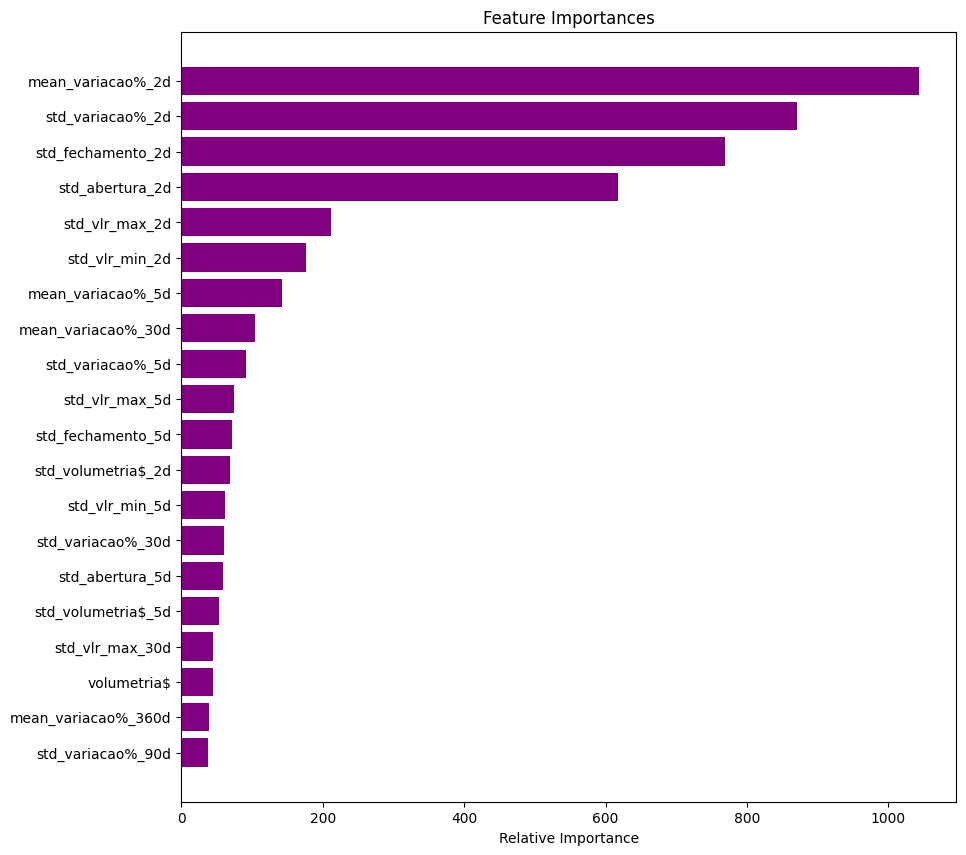

In [ ]:
# Obtendo a importância das features
importances = model.feature_importances_

# Ordenando as features por importância
indices = np.argsort(importances)

# Selecionando as 20 features mais importantes
indices = indices[-20:]

# Plotando a importância das features
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [feats[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Realizando a validação cruzada com 5 folds
scores = cross_val_score(model, df[feats], df['target'], cv=5)

print(f"Scores da validação cruzada: {scores}")
print(f"Média dos scores: {scores.mean()}")

[LightGBM] [Info] Number of positive: 1962, number of negative: 1813
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2640
[LightGBM] [Info] Number of data points in the train set: 3775, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519735 -> initscore=0.078981
[LightGBM] [Info] Start training from score 0.078981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
# Criando a coluna predict_target no df contendo as predições do modelo

df['predict_target'] = df_predictions

In [ ]:
# Vendo as 5 primeiras linhas do df

df.head()

,data,fechamento,abertura,vlr_max,vlr_min,volumetria$,variacao%,mean_fechamento_2d,std_fechamento_2d,mean_fechamento_5d,...,mean_volumetria$_90d,std_volumetria$_90d,mean_volumetria$_180d,std_volumetria$_180d,mean_volumetria$_360d,std_volumetria$_360d,mean_volumetria$_540d,std_volumetria$_540d,target,predict_target
4719,2005-01-03,25.722,26.193,26.492,25.671,115640000.0,-1.81,61.96025,0.408354,61.9506,...,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06,0,0
4718,2005-01-04,24.848,25.722,25.873,24.791,146140000.0,-3.40,25.28500,0.618011,61.9506,...,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06,0,0
4717,2005-01-05,24.692,24.859,25.001,24.523,127420000.0,-0.63,24.77000,0.110309,61.9506,...,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06,0,0
4716,2005-01-06,24.367,24.695,24.808,24.250,151170000.0,-1.32,24.52950,0.229810,61.9506,...,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06,0,0
4715,2005-01-07,24.747,24.376,24.874,24.376,104960000.0,1.56,24.55700,0.268701,24.8752,...,4.012167e+06,1.142995e+06,4.052917e+06,1.172197e+06,4.046225e+06,1.195383e+06,3.981606e+06,1.543419e+06,1,1


# Salvando df Escorado como csv

In [ ]:
# Salvando df escorado

#df.to_csv(r'C:\Users\CPU\Documents\Repositories\Study\Data_Science_Projects\Studies\Data\base_ibovespa_escorada_lgbm.csv', index=False)